In [ ]:
########################################################################
############# INSTALL PACKAGES #########################################
########################################################################

install.packages("INLA",repos=c(getOption("repos"),INLA="https://inla.r-inla-download.org/R/stable"), dep=TRUE)
install.packages("fmesher", dependencies = TRUE)
install.packages("MatrixModels", type = "source")
install.packages("exactextractr")
install.packages("sn" ,dependencies = TRUE)
packages <- c("terra","dplyr","spdep", "exactextractr", "sf","ggplot2","viridis","sn","fmesher","exactextractr","fields")
package.check <- lapply(packages, FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
        install.packages(x, dependencies = TRUE)
        library(x, character.only = TRUE, quietly=TRUE)
    }
})
Sys.setenv("AWS_DEFAULT_REGION" = 'us-west-2')

In [1]:
library("fmesher")
library(MatrixModels)
library(Matrix)
library(INLA)
library(inlabru)
library("jpeg")
library(gstat)
library(MatrixModels)

library(sf)
library(terra)
library(dplyr)
library(spdep)
library(raster)
library(exactextractr)

library(ggplot2)
library(viridis)
library(stringr)

Linking to GEOS 3.12.1, GDAL 3.8.5, PROJ 9.4.0; sf_use_s2() is TRUE

terra 1.7.78


Attaching package: ‘dplyr’


The following objects are masked from ‘package:terra’:

    intersect, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Loading required package: sp


Attaching package: ‘raster’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: viridisLite



In [60]:
#####################################################
######## GENERATE PSU-LEVEL NFI VALUES ##############
#####################################################

library(sf)
library(terra)

nfi <- st_read("/projects/my-private-bucket/Data/NFI_data/Brazil/Brazil_NFI_dated.gpkg")
all_subunits <- data.frame(
  Subunidade = rep(1:4, each = length(unique(nfi$UA))),
  UA = rep(unique(nfi$UA), times = 4)
)

nfi_full <- merge(all_subunits, nfi, by = c("UA", "Subunidade"), all.x = TRUE)

missing_rows <- is.na(nfi_full$AGB_Mg.ha2)

nfi_full[missing_rows, c("AGB_Mg.ha2", "AGB_Mg")] <- 0

fill_missing_values <- function(x) {
  ifelse(is.na(x), x[!is.na(x)][1], x)  # Take the first non-NA value in the vector
}

# # nfi_full$Biome <- ave(nfi_full$Biome, nfi_full$UA, FUN = fill_missing_values)
# # nfi_full$Brazil <- ave(nfi_full$Brazil, nfi_full$UA, FUN = fill_missing_values)
# # nfi_full$lon_pc <- ave(nfi_full$lon_pc, nfi_full$UA, FUN = fill_missing_values)
# # nfi_full$lat_pc <- ave(nfi_full$lat_pc, nfi_full$UA, FUN = fill_missing_values)
# # nfi_full$Date_of_measurement <- ave(nfi_full$Date_of_measurement, nfi_full$UA, FUN = fill_missing_values)

nfi_full$Biome <- ave(as.vector(nfi_full$Biome), nfi_full$UA, FUN = fill_missing_values)
nfi_full$Subunidade <- ave(as.vector(nfi_full$Subunidade), nfi_full$UA, FUN = fill_missing_values)
nfi_full$State <- ave(as.vector(nfi_full$State), nfi_full$UA, FUN = fill_missing_values)
nfi_full$lon_pc <- ave(as.vector(nfi_full$lon_pc), nfi_full$UA, FUN = fill_missing_values)
nfi_full$lat_pc <- ave(as.vector(nfi_full$lat_pc), nfi_full$UA, FUN = fill_missing_values)
nfi_full$Date_of_measurement <- ave(as.vector(nfi_full$Date_of_measurement), nfi_full$UA, FUN = fill_missing_values)

nfi_full_sf <- st_as_sf(nfi_full, coords = c("lon_pc", "lat_pc"), crs = st_crs(nfi))
st_write(nfi_full_sf, "/projects/my-private-bucket/Data/NFI_data/Brazil/Brazil_NFI_filled.gpkg")

Reading layer `t2_agb_acrosscluster_dated' from data source 
  `/projects/my-private-bucket/Data/NFI_data/Brazil/Brazil_NFI_dated.gpkg' 
  using driver `GPKG'
Simple feature collection with 16256 features and 9 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -73.0802 ymin: -24.11986 xmax: -37.80046 ymax: 4.139996
Geodetic CRS:  WGS 84


UA     Subunidade AGB_Mg.ha2 AGB_Mg    Biome    State lon_pc    lat_pc   
1     AC_108 1           72.82653   7.282653 Amazônia AC    -70.92032 -8.459941
2     AC_108 2          184.62476  18.462476 Amazônia AC    -70.92032 -8.459941
3     AC_108 3          111.69185  11.169185 Amazônia AC    -70.92032 -8.459941
4     AC_108 4          148.31202  14.831202 Amazônia AC    -70.92032 -8.459941
5     AC_109 1           72.22946   7.222946 Amazônia AC    -70.74003 -8.459831
6     AC_109 2           61.31275   6.131275 Amazônia AC    -70.74003 -8.459831
7     AC_109 3            0.00000   0.000000 Amazônia AC    -70.74003 -8.459831
8     AC_109 4            0.00000   0.000000 Amazônia AC    -70.74003 -8.459831
9     AC_110 1          101.71134  10.171134 Amazônia AC    -70.56035 -8.459664
10    AC_110 2           92.99692   9.299692 Amazônia AC    -70.56035 -8.459664
11    AC_110 3           34.63033   3.463033 Amazônia AC    -70.56035 -8.459664
12    AC_110 4           59.69169   5.969169 Amazônia AC    -70.56035 -8.459664
13    AC_111 1          142.65704  14.265704 Amazônia AC    -70.38034 -8.459801
14    AC_111 2          396.03636  39.603636 Amazônia AC    -70.38034 -8.459801
15    AC_111 3          299.05820  29.905820 Amazônia AC    -70.38034 -8.459801
16    AC_111 4          379.00377  37.900377 Amazônia AC    -70.38034 -8.459801
17    AC_112 1            0.00000   0.000000 Amazônia AC    -70.20008 -8.460010
18    AC_112 2           14.86907   1.486907 Amazônia AC    -70.20008 -8.460010
19    AC_112 3            0.00000   0.000000 Amazônia AC    -70.20008 -8.460010
20    AC_112 4            0.00000   0.000000 Amazônia AC    -70.20008 -8.460010
21    AC_113 1          161.17638  16.117638 Amazônia AC    -70.02039 -8.459682
22    AC_113 2          168.27584  16.827584 Amazônia AC    -70.02039 -8.459682
23    AC_113 3          197.58222  19.758222 Amazônia AC    -70.02039 -8.459682
24    AC_113 4           90.83946   9.083946 Amazônia AC    -70.02039 -8.459682
25    AC_114 1          226.59800  22.659800 Amazônia AC    -69.84021 -8.459906
26    AC_114 2          143.34097  14.334097 Amazônia AC    -69.84021 -8.459906
27    AC_114 3          191.68773  19.168773 Amazônia AC    -69.84021 -8.459906
28    AC_114 4          141.46302  14.146302 Amazônia AC    -69.84021 -8.459906
29    AC_115 1          172.14519  17.214519 Amazônia AC    -69.66039 -8.459680
30    AC_115 2          168.39626  16.839626 Amazônia AC    -69.66039 -8.459680
⋮     ⋮      ⋮          ⋮          ⋮         ⋮        ⋮     ⋮         ⋮        
19723 TO_90  3          61.662002  6.1662002 Amazônia TO    -49.14026 -7.740007
19724 TO_90  4          52.744999  5.2744999 Amazônia TO    -49.14026 -7.740007
19725 TO_91  1           0.000000  0.0000000 Amazônia TO    -48.96053 -7.739740
19726 TO_91  2           0.000000  0.0000000 Amazônia TO    -48.96053 -7.739740
19727 TO_91  3           0.000000  0.0000000 Amazônia TO    -48.96053 -7.739740
19728 TO_91  4           4.496930  0.4496930 Amazônia TO    -48.96053 -7.739740
19729 TO_92  1           0.000000  0.0000000 Amazônia TO    -48.78051 -7.739813
19730 TO_92  2           4.090449  0.4090449 Amazônia TO    -48.78051 -7.739813
19731 TO_92  3           6.513815  0.6513815 Amazônia TO    -48.78051 -7.739813
19732 TO_92  4          12.628678  1.2628678 Amazônia TO    -48.78051 -7.739813
19733 TO_93  1          29.201169  2.9201169 Cerrado  TO    -48.60033 -7.739848
19734 TO_93  2          17.415767  1.7415767 Cerrado  TO    -48.60033 -7.739848
19735 TO_93  3          28.955905  2.8955905 Cerrado  TO    -48.60033 -7.739848
19736 TO_93  4          44.584137  4.4584137 Cerrado  TO    -48.60033 -7.739848
19737 TO_94  1           0.000000  0.0000000 Cerrado  TO    -48.42028 -7.739791
19738 TO_94  2           1.651842  0.1651842 Cerrado  TO    -48.42028 -7.739791
19739 TO_94  3           1.209173  0.1209173 Cerrado  TO    -48.42028 -7.739791
19740 TO_94  4           0.000000  0.0000000 Cerrado  TO    -48.42028 -7.739791
19741 

In [ ]:
###############################################
###### READ CCI TILES AND MOSAIC TILES ########
###############################################

# library(terra)
# library(sf)
# gpkg_file <- "/projects/my-private-bucket/Data/NFI_data/Brazil/Brazil_NFI_filled.gpkg"  
# gpkg <- st_read(gpkg_file)
# gpkg_bbox <- st_bbox(gpkg)
# crs_gpkg <- st_crs(gpkg)

# folder_path <- "/projects/my-public-bucket/Data/Biomass_maps/CCI_2021_v5/dap.ceda.ac.uk/neodc/esacci/biomass/data/agb/maps/v5.01/geotiff/2021"
# tiff_files <- list.files(folder_path, pattern = "*_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2021-fv5.0.tif", full.names = TRUE)
# overlapping_tiffs <- list()

# for (tiff_file in tiff_files) {
#   raster <- rast(tiff_file)
#   raster_bbox <- ext(raster)
#   raster_bbox_sf <- st_sfc(st_polygon(list(matrix(c(raster_bbox[1], raster_bbox[3],  # xmin, ymin
#                                                    raster_bbox[2], raster_bbox[3],  # xmax, ymin
#                                                    raster_bbox[2], raster_bbox[4],  # xmax, ymax
#                                                    raster_bbox[1], raster_bbox[4],  # xmin, ymax
#                                                    raster_bbox[1], raster_bbox[3]),  # Repeating first point to close polygon
#                                                  ncol = 2, byrow = TRUE))))
#   gpkg_bbox_sf <- st_sfc(st_polygon(list(matrix(c(gpkg_bbox["xmin"], gpkg_bbox["ymin"],  # xmin, ymin
#                                                    gpkg_bbox["xmax"], gpkg_bbox["ymin"],  # xmax, ymin
#                                                    gpkg_bbox["xmax"], gpkg_bbox["ymax"],  # xmax, ymax
#                                                    gpkg_bbox["xmin"], gpkg_bbox["ymax"],  # xmin, ymax
#                                                    gpkg_bbox["xmin"], gpkg_bbox["ymin"]),  # Repeating first point to close polygon
#                                                  ncol = 2, byrow = TRUE))))
#   overlap <- st_intersects(gpkg_bbox_sf, raster_bbox_sf, sparse = FALSE)
#   if (any(overlap)) {
#     overlapping_tiffs <- append(overlapping_tiffs, tiff_file)
#   }
# }

# print(overlapping_tiffs)
# rasters <- lapply(overlapping_tiffs, rast)
# merged_raster <- do.call(merge, rasters)
# output_file <- "/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/CCI_Brazil.tif"
# writeRaster(merged_raster, output_file, gdal = c("COMPRESS=LZW", "TILED=YES", "BIGTIFF=YES"),overwrite = TRUE)

Reading layer `Brazil_NFI_filled' from data source 
  `/projects/my-private-bucket/Data/NFI_data/Brazil/Brazil_NFI_filled.gpkg' 
  using driver `GPKG'
Simple feature collection with 19752 features and 7 fields (with 3496 geometries empty)
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -73.0802 ymin: -24.11986 xmax: -37.80046 ymax: 4.139996
Geodetic CRS:  WGS 84


Cannot preload entire working area of 1306366542 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Warning message in .local(x, y, ...):
“Polygons transformed to raster CRS (EPSG:4326)”
Cannot preload entire working area of 39877700 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
Reading layer `NFI_and_COVS' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/NFI_and_COVS.gpkg' 
  using driver `GPKG'
Simple feature collection with 4938 features and 5 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -7051237 ymin: -2989196 xmax: -3647226 ymax: 527705.7
Projected CRS: WGS 84 / NSIDC EASE-Grid 2.0 Global


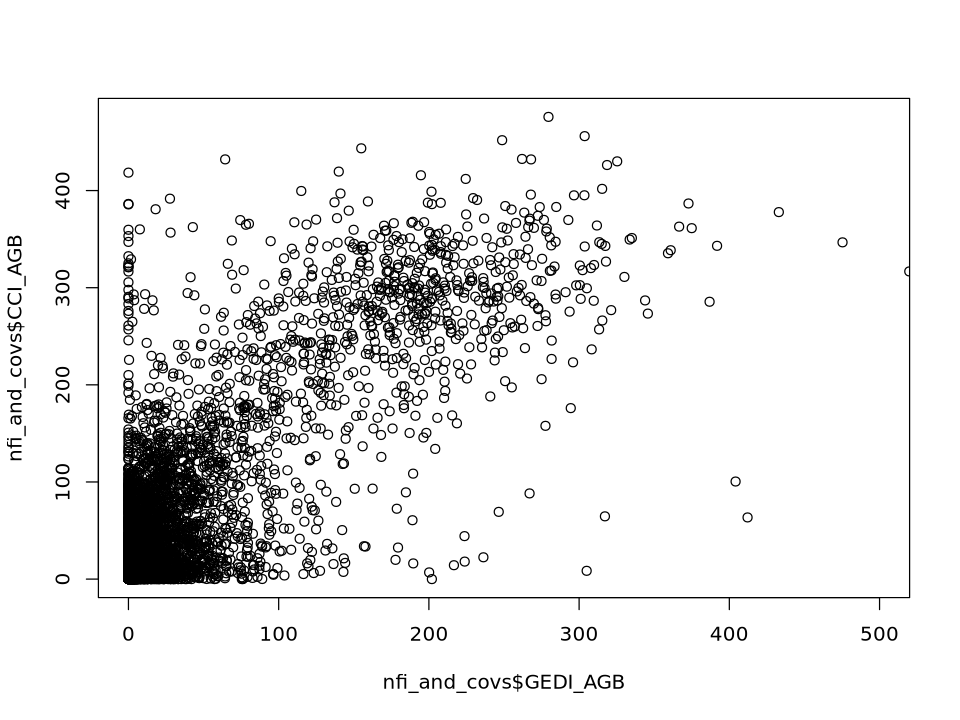

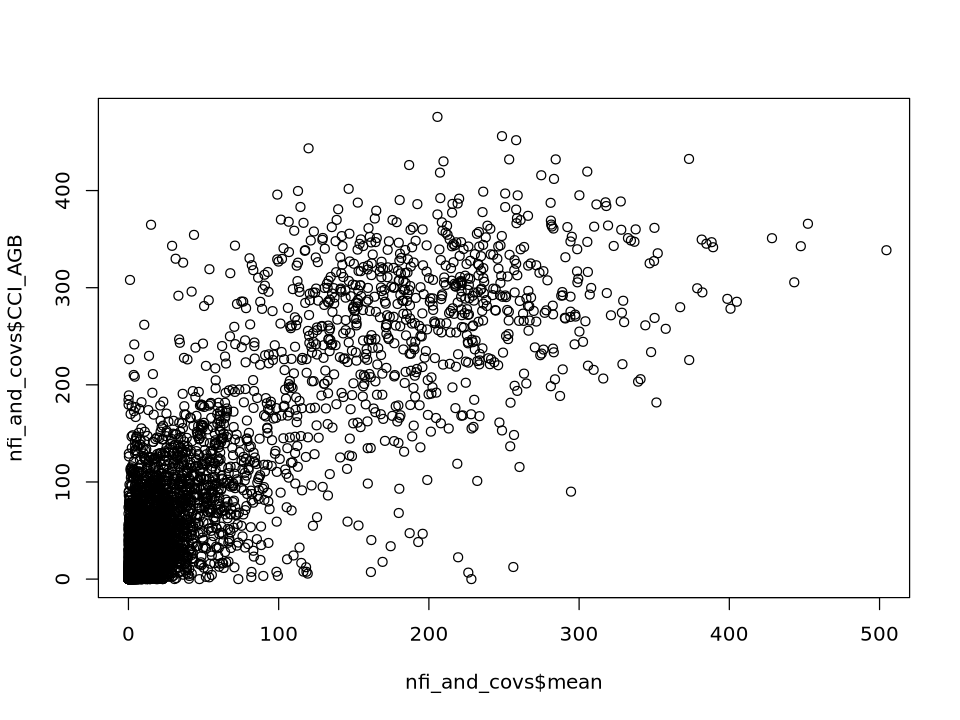


Call:
lm(formula = nfi_and_covs$mean ~ nfi_and_covs$GEDI_AGB * nfi_and_covs$CCI_AGB)

Residuals:
    Min      1Q  Median      3Q     Max 
-278.85  -13.06   -0.25    6.37  705.18 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                -2.072e+00  8.584e-01  -2.414
nfi_and_covs$GEDI_AGB                       1.975e-01  1.995e-02   9.903
nfi_and_covs$CCI_AGB                        4.700e-01  1.091e-02  43.083
nfi_and_covs$GEDI_AGB:nfi_and_covs$CCI_AGB  3.574e-04  8.083e-05   4.422
                                           Pr(>|t|)    
(Intercept)                                  0.0158 *  
nfi_and_covs$GEDI_AGB                        <2e-16 ***
nfi_and_covs$CCI_AGB                         <2e-16 ***
nfi_and_covs$GEDI_AGB:nfi_and_covs$CCI_AGB    1e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 41.48 on 4934 degrees of freedom
Multiple R-squared:  0.7078,	Adjus

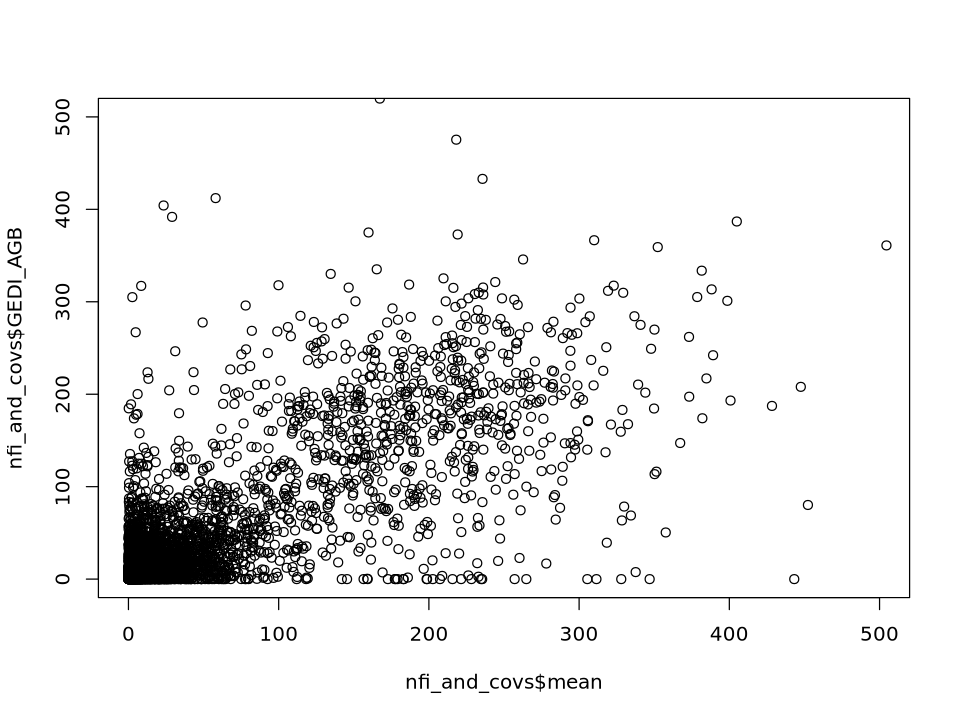

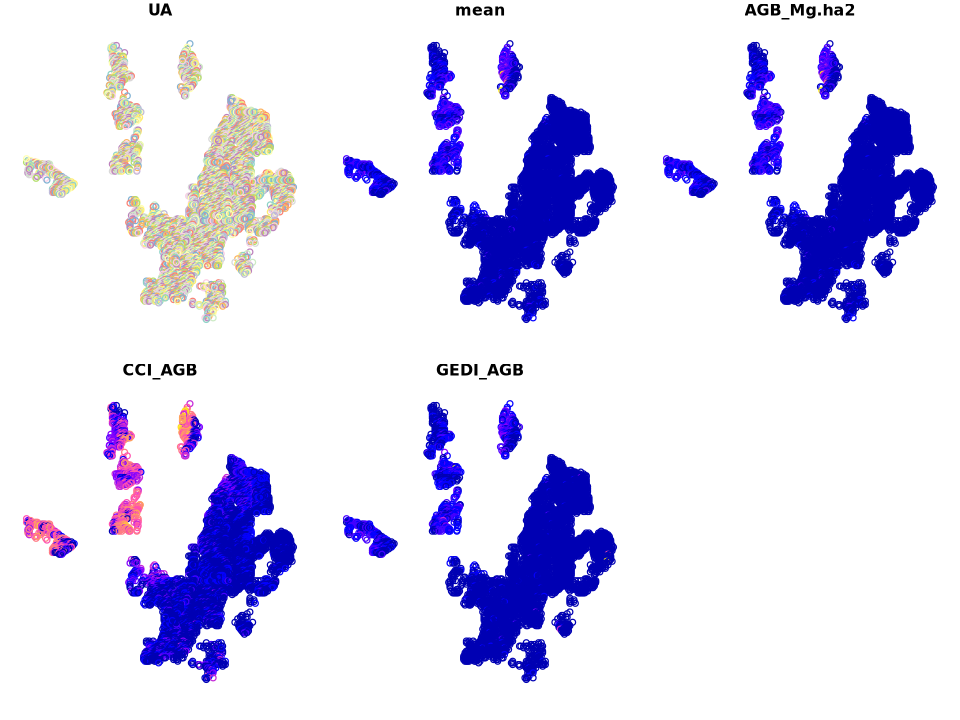

In [6]:
###############################################
###### PREPARE DATASET FOR ANALYSIS  ##########
###############################################

nfi_and_covs <- st_read("/projects/my-private-bucket/Data/NFI_data/Brazil/Brazil_NFI_filled.gpkg") %>% st_transform(crs=6933)
nfi_and_covs <- nfi_and_covs %>% group_by(UA) %>% summarise(mean = mean(AGB_Mg.ha2))
nfi_and_covs$AGB_Mg.ha2 <- nfi_and_covs$mean

CCI <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/CCI_Brazil_6933.tif")
CCI_AGB <- exactextractr::exact_extract(CCI,st_buffer(nfi_and_covs,100), 'mean')
nfi_and_covs$CCI_AGB <- CCI_AGB

GEDI <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/GEDI_Brazil_500m.tif") # L4A producted, gridded to 500 m 
GEDI_AGB <- exactextractr::exact_extract(GEDI,st_buffer(nfi_and_covs,100), 'mean')
nfi_and_covs$GEDI_AGB <- GEDI_AGB

# st_write(nfi_and_covs,"/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/NFI_and_COVS.gpkg")

nfi_and_covs <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/NFI_and_COVS.gpkg")  %>% st_transform("epsg:6933")

plot(nfi_and_covs$GEDI_AGB,nfi_and_covs$CCI_AGB,xlim=c(0,500))
plot(nfi_and_covs$mean,nfi_and_covs$CCI_AGB,xlim=c(0,500))
plot(nfi_and_covs$mean,nfi_and_covs$GEDI_AGB,xlim=c(0,500),ylim=c(0,500))

summary(lm(nfi_and_covs$mean ~ nfi_and_covs$GEDI_AGB * nfi_and_covs$CCI_AGB))
plot(nfi_and_covs)

In [7]:
###############################################
################ START ANALYSIS  ##############
###############################################

# AOI <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/AOI_provinces_Amazon.gpkg") %>% st_make_valid() %>% st_union() %>% st_transform("epsg:6933")
# st_write(AOI, "/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/AOI_provinces_Amazon_DISS.gpkg")

Brazil <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/AOI_provinces_DISS.gpkg")
Brazil <- Brazil %>% st_transform(crs=6933)

CCI <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/CCI_Brazil_6933.tif")
GEDI <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/GEDI_Brazil_500m.tif") 

nfi_and_covs <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/NFI_and_COVS.gpkg")  %>% st_transform("epsg:6933")
nfi_and_covs <- st_intersection(nfi_and_covs, Brazil)

nfi_and_covs$X <- (as.data.frame(st_coordinates(nfi_and_covs)))$X
nfi_and_covs$Y <- (as.data.frame(st_coordinates(nfi_and_covs)))$Y
write.csv(nfi_and_covs %>% st_drop_geometry(), "/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/DATA.csv")

Reading layer `AOI_provinces_DISS' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/AOI_provinces_DISS.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 0 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -73.99048 ymin: -24.31781 xmax: -37.74438 ymax: 4.508911
Geodetic CRS:  Undefined geographic SRS
Reading layer `NFI_and_COVS' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/NFI_and_COVS.gpkg' 
  using driver `GPKG'
Simple feature collection with 4938 features and 5 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -7051237 ymin: -2989196 xmax: -3647226 ymax: 527705.7
Projected CRS: WGS 84 / NSIDC EASE-Grid 2.0 Global


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


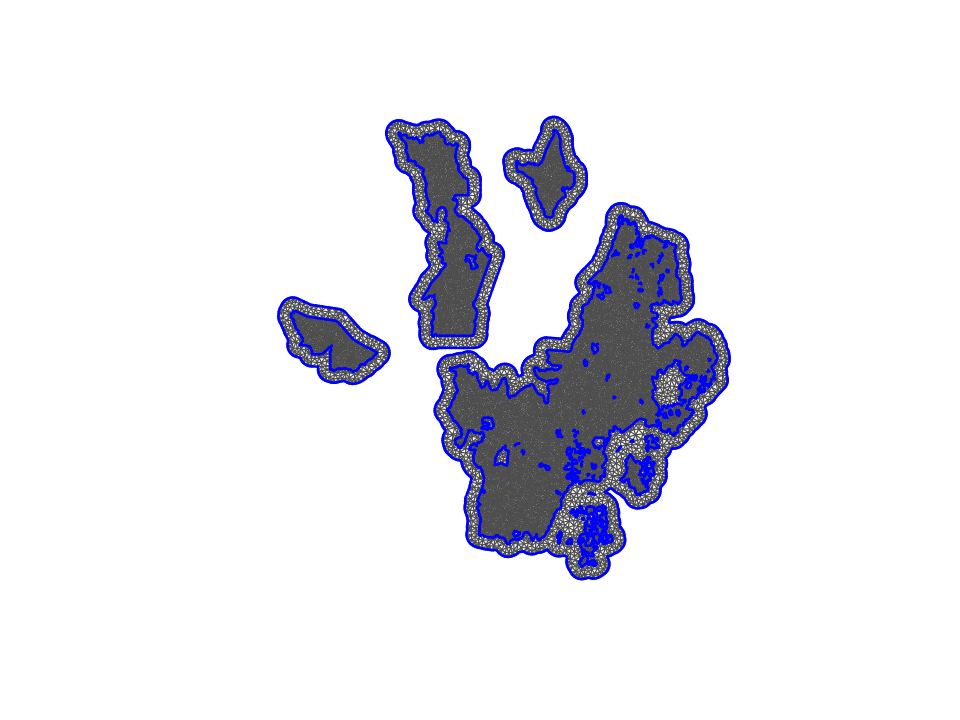

In [8]:
###################################################################
################ BEGIN MODELING - CREATE INLA MESH ################
###################################################################

options(repr.plot.width=8, repr.plot.height=6)

DATA <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/DATA.csv")
DATA <- DATA[DATA$GEDI_AGB > 0,]
DATA <- DATA[DATA$AGB_Mg.ha2 > 0,]
DATA <- DATA[DATA$CCI_AGB > 0,]
factor <- (1/3)
DATA$AGB_Mg.ha2 <- (DATA$AGB_Mg.ha2)^factor

loc.plot <- data.matrix(as.data.frame(cbind(DATA$X,DATA$Y)))
nfi.agbd <- DATA$AGB_Mg.ha2 
gedi.agbd <- DATA$GEDI_AGB
cci.agbd <- DATA$CCI_AGB

max.edge = 20*10^3
Brazil.buffer = st_buffer(Brazil, dist = max.edge*5) # We also make a 5 km buffer around Brazil to prevent boundary effects.
mesh = inla.mesh.2d(boundary = list(as(Brazil, "Spatial"), as(Brazil.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 
k = mesh$n ### This is the resulting number of vertices
loc.plot <- data.matrix(loc.plot) #In case loc.plot is a df rather than matrix, use "loc.plot <- data.matrix(loc.plot)"
plot(mesh)

n.plot = nrow(loc.plot)
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot) # make a new projector matrix with the new mesh and the same plot locations. 

Time used:
    Pre = 1.44, Running = 242, Post = 3.68, Total = 247 
Fixed effects:
           mean    sd 0.025quant 0.5quant 0.975quant  mode kld
intercept 1.635 0.079      1.481    1.635      1.790 1.635   0
L4A       0.006 0.000      0.005    0.006      0.007 0.006   0
CCI       0.012 0.001      0.010    0.012      0.014 0.012   0

Random effects:
  Name	  Model
    alpha.spat SPDE2 model
   beta.spat SPDE2 model
   eta.spat SPDE2 model

Model hyperparameters:
                                            mean       sd 0.025quant 0.5quant
Precision for the Gaussian observations 1.86e+00 5.00e-02   1.76e+00 1.86e+00
Range for alpha.spat                    4.74e+05 1.09e+05   2.98e+05 4.61e+05
Stdev for alpha.spat                    3.03e-01 3.90e-02   2.33e-01 3.01e-01
Range for beta.spat                     7.13e+04 1.94e+04   4.03e+04 6.89e+04
Stdev for beta.spat                     5.00e-03 0.00e+00   4.00e-03 5.00e-03
Range for eta.spat                      5.49e+05 1.51e+05   3.16e

[1] 0.9488243

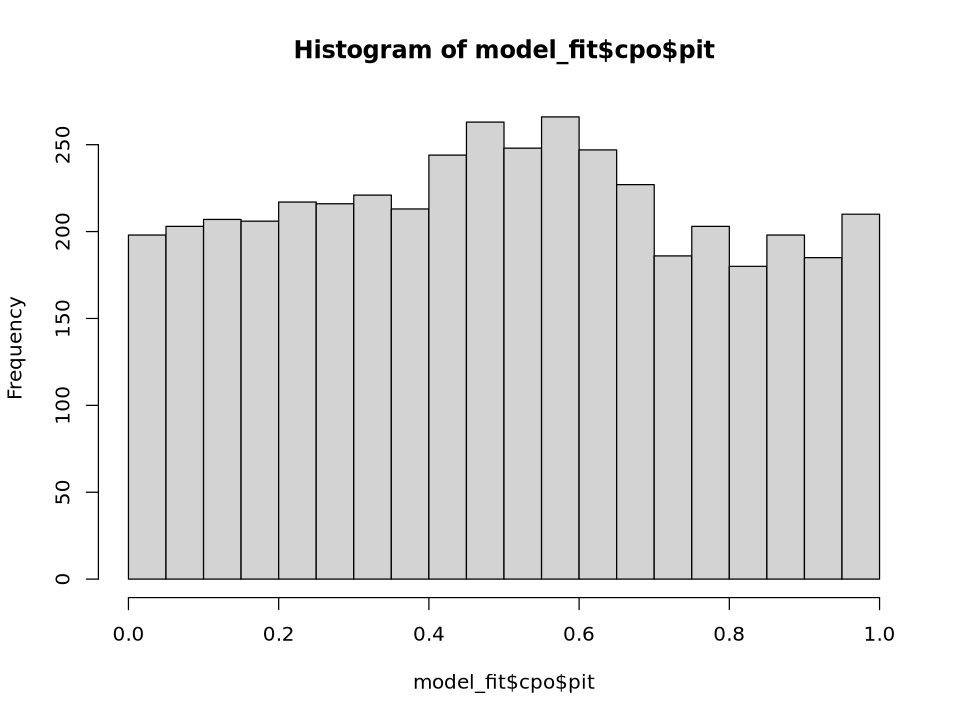

In [9]:
###############################################################
################ SET PRIORS AND RUN MODEL #####################
###############################################################

# Priors for the varying intercept alpha_tilde
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(30*10^3, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(60, 0.01)) # This says the probability that the SD is GREATER than 60 Mg/ha is 0.01

# Priors for the varying coefficient beta_tilde
spde.beta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30*10^3, 0.01), # Same interpretations as above here
                                prior.sigma = c(1, 0.5)) # This says the probability that the SD is GREATER than 1 is 0.5


# Priors for the varying coefficient eta_tilde
spde.eta = inla.spde2.pcmatern(mesh, 
                               prior.range = c(30*10^3, 0.01), # Same interpretations as above here
                               prior.sigma = c(1, 0.5)) # This says the probability that the SD is GREATER than 1 is 0.5


### Construct our formula #####
formula = agbd ~
  -1 + # removes the automatic intercept so you can include your named intercept
  intercept + 
  L4A + 
  CCI + 
  f(alpha.spat, model = spde.alpha) + 
  f(beta.spat, model = spde.beta) + 
  f(eta.spat, model = spde.eta)

## Arrange our data so we can supply it to INLA to input in the formula above #####
stack = inla.stack(data = list(agbd = nfi.agbd),
                   A = list(1, # tell INLA we expect an intercept, and the projection matrix is just "1"
                            1, # tell INLA we expect a GEDI value, and the projection matrix for its parameter is just "1"
                            1, # tell INLA we expect a CCI value, and the projection matrix for its parameter is just "1"
                            A.plot, # tell INLA we have a mesh projected onto the plot locations for alpha-tilde 
                            Diagonal(x = gedi.agbd)%*%A.plot, # tell INLA to multiply our mesh with GEDI values for Beta-tilde
                            Diagonal(x = cci.agbd)%*%A.plot), # tell INLA to multiply our mesh with CCI values for eta-tilde
                   effects = list(
                     intercept = rep(1, n.plot), # The intercept just given an index equal to 1
                     L4A = gedi.agbd, # Supply INLA with the GEDI values
                     CCI = cci.agbd, # Supply INLA with the CCI values
                     alpha.spat = 1:k, # The random effects just need to given unique indices at each mesh node.
                     beta.spat = 1:k, #, # The random effects just need to given unique indices at each mesh node.
                     eta.spat = 1:k # The random effects just need to given unique indices at each mesh node.
                   ))

model_fit = inla(formula = formula, # Provide the formula
                 family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                 data = inla.stack.data(stack), # These line and the one below are simply how we feed INLA the stack.
                 control.predictor = list(A = inla.stack.A(stack)),
                 control.compute = list(config = T, dic = T, waic = T, cpo = T),
                 control.inla = list(int.strategy = "eb"), # EB just fixes the hyperparameters at their maximum posterior (like maximum likelihood, but accounting for priors) values. The other methods manually integrate across the range of possible values.
                 verbose = TRUE)

summary(model_fit)
save(model_fit, file = "/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/INLA_model_fit.RData")
hist(model_fit$cpo$pit, breaks = 20) 

PITs <- model_fit$cpo$pit
length(PITs[PITs >= 0.025 & PITs <= 0.975])/length(PITs)

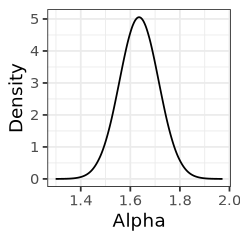

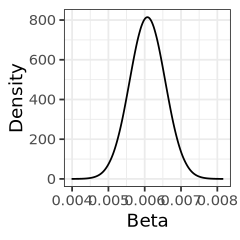

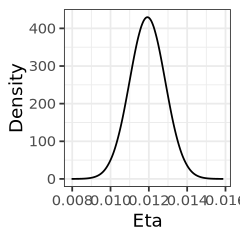

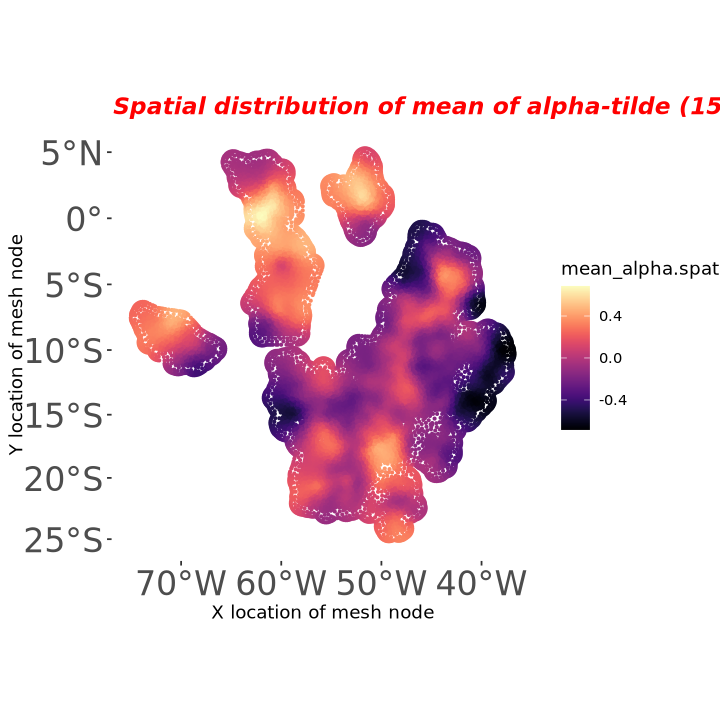

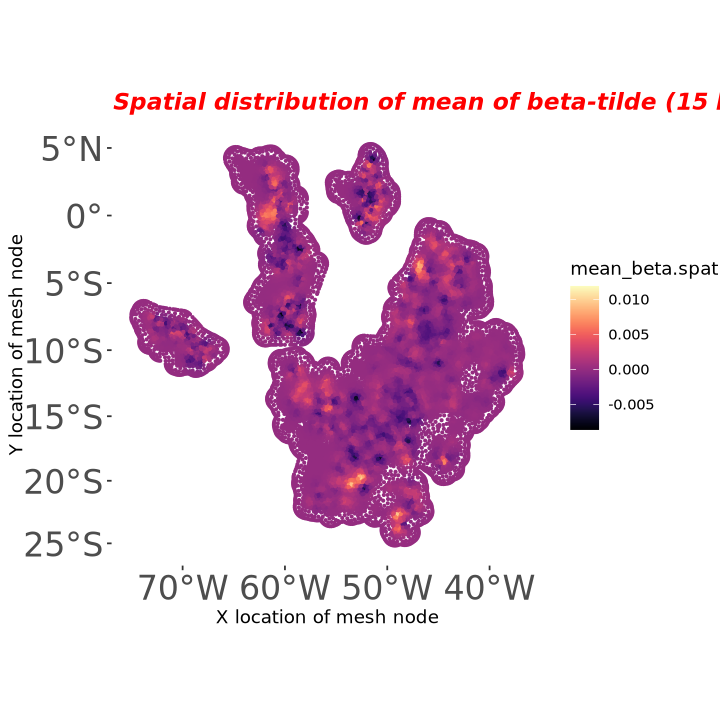

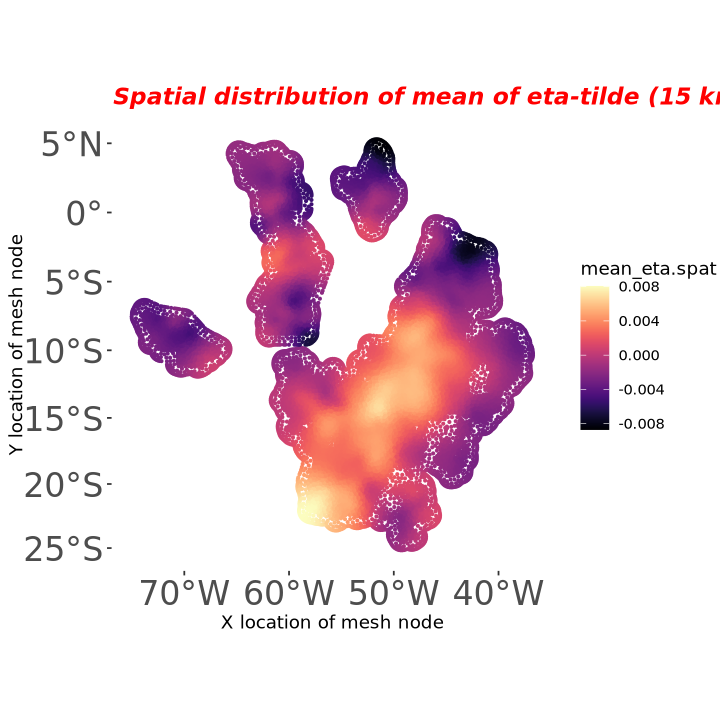

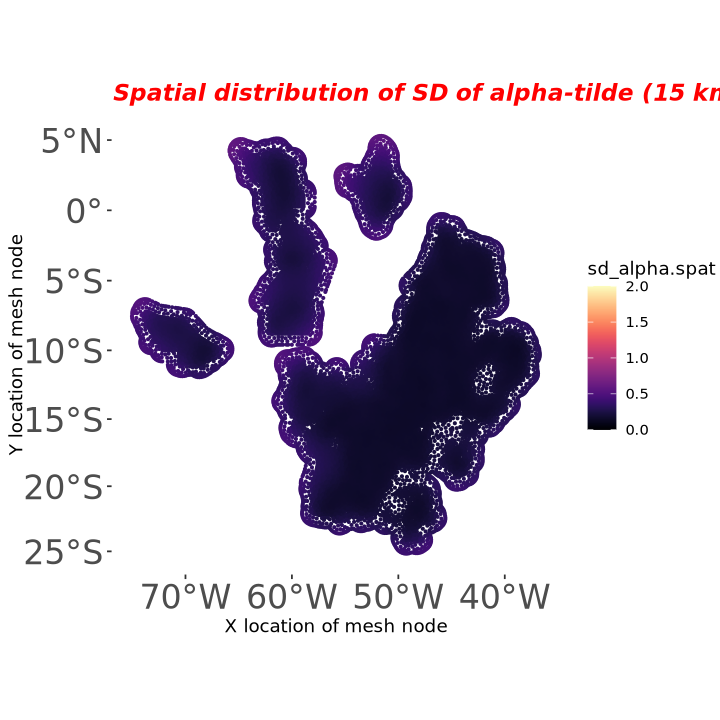

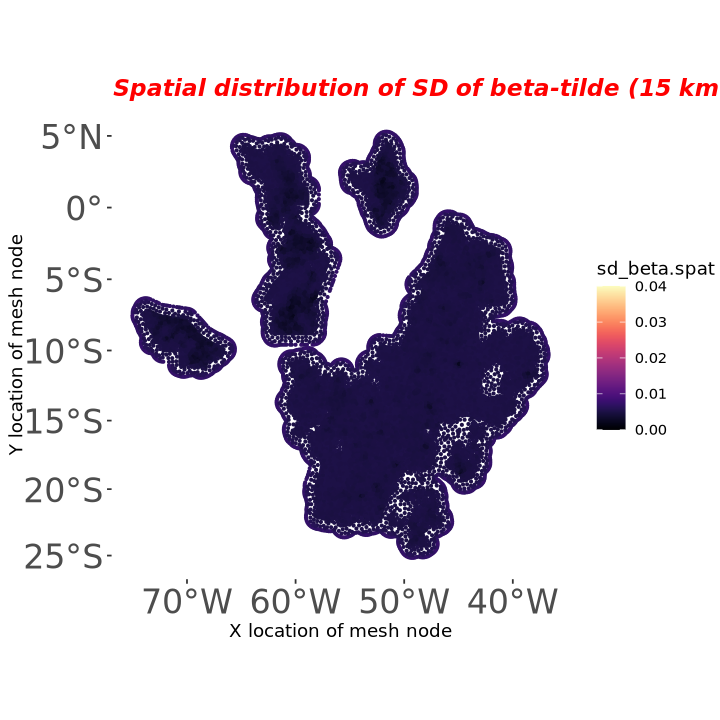

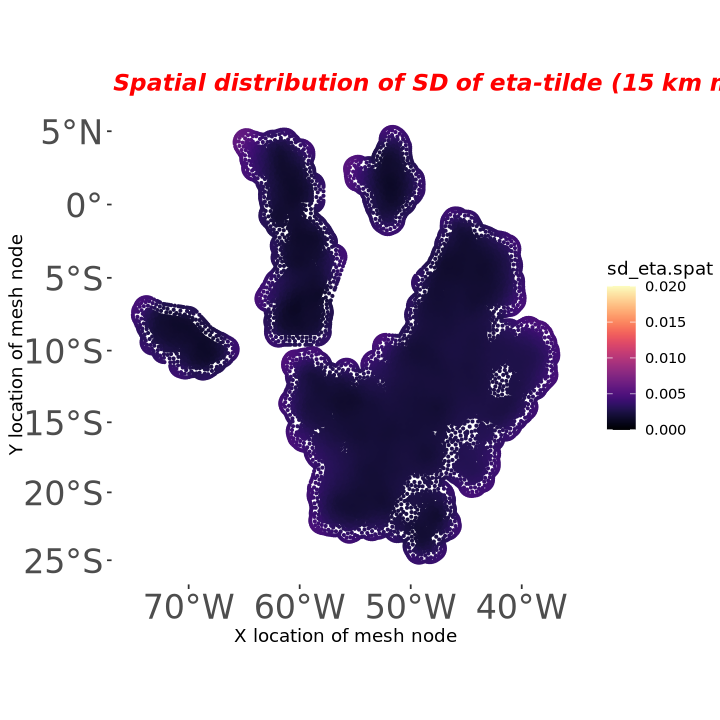

In [10]:
#############################################################################################
##################### LETS VISUALIZE THE MODEL PARAMETERS ###################################
#############################################################################################

options(repr.plot.width=2, repr.plot.height=2)
load("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/INLA_model_fit.RData")

# When inla() is executed, we obtain an object of class "inla" that contains the information of the fitted model 
# including summaries and posterior marginal densities of the fixed effects, 
# the random effects, and the hyperparameters (and many more things, but we explore only these for now). 

# The fixed effects are straighforward to understand. Below, we see the posterior elements of the intercept alpha, and parameters beta and eta. 
alpha <- model_fit$marginals.fixed[[1]]
beta <- model_fit$marginals.fixed[[2]]
eta <- model_fit$marginals.fixed[[3]]
ggplot(data.frame(inla.smarginal(alpha)), aes(x, y)) + geom_line() + theme_bw() + xlab("Alpha") + ylab("Density")
ggplot(data.frame(inla.smarginal(beta)), aes(x, y)) + geom_line() + theme_bw() + xlab("Beta") + ylab("Density")
ggplot(data.frame(inla.smarginal(eta)), aes(x, y)) + geom_line() + theme_bw() + xlab("Eta") + ylab("Density")

# The random effects, in our case, are also easy to understand from the model outputs. The posterior distributions of the range and SD of alpha.spat, 
# beta.spat and eta.spat show us how these random effects vary across Mexico.

options(repr.plot.width=6, repr.plot.height=6)

mean_alpha.spat <- model_fit$summary.random[[1]]$mean # mean values of alpha.spat at each mesh vertex
sd_alpha.spat <- model_fit$summary.random[[1]]$sd # standard deviation of alpha.spat at each mesh node 

mean_beta.spat <- model_fit$summary.random[[2]]$mean # mean values of alpha.spat at each mesh vertex
sd_beta.spat <- model_fit$summary.random[[2]]$sd # standard deviation of alpha.spat at each mesh node 

mean_eta.spat <- model_fit$summary.random[[3]]$mean # mean values of alpha.spat at each mesh vertex
sd_eta.spat <- model_fit$summary.random[[3]]$sd # standard deviation of alpha.spat at each mesh node 

ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = mean_alpha.spat),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(option="magma") + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of mean of alpha-tilde (15 km mesh)") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(),axis.text=element_text(size=20),axis.title=element_text())
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = mean_beta.spat),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(option="magma") + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of mean of beta-tilde (15 km mesh)") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(),axis.text=element_text(size=20),axis.title=element_text())
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = mean_eta.spat),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
          scale_color_viridis(option="magma") + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of mean of eta-tilde (15 km mesh)") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(),axis.text=element_text(size=20),axis.title=element_text())
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = sd_alpha.spat),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(option="magma",limits=c(0,2)) + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of SD of alpha-tilde (15 km mesh)") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(),axis.text=element_text(size=20),axis.title=element_text())
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = sd_beta.spat),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(option="magma",limits=c(0,0.04)) + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of SD of beta-tilde (15 km mesh)") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(),axis.text=element_text(size=20),axis.title=element_text())
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = mesh$loc[,1], y = mesh$loc[,2], col = sd_eta.spat),size=0.5) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(option="magma",limits=c(0,0.02)) + xlab("X location of mesh node") + ylab("Y location of mesh node") + ggtitle("Spatial distribution of SD of eta-tilde (15 km mesh)") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(),axis.text=element_text(size=20),axis.title=element_text())
options(repr.plot.width=4, repr.plot.height=4)

# DIC, WAIC and the CPO and PIT are standard Bayesian model diagnostics, which tell us how our model is performing. 

Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


[1] 0.8553915

[1] 30.06869

[1] 0.2230182

[1] 0.9617335

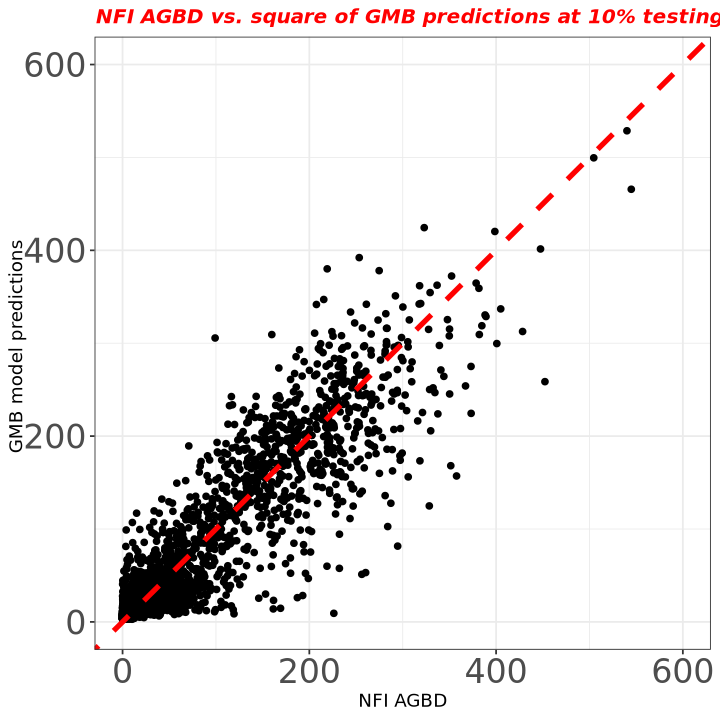

In [12]:
###############################################################
######## SCATTER PLOT OF PREDICTIONS VS. NFI-ESTIMATES ########
###############################################################

samples = inla.posterior.sample(n = 250, result = model_fit) # Draw posterior samples from our model fit 

# Our model function
pred_fun = function(...){
  drop(intercept + 
         gedi.agbd*L4A +
         cci.agbd*CCI +
         A.plot%*%alpha.spat[1:k] +   
         Diagonal(x = gedi.agbd)%*%A.plot%*%beta.spat[1:k] + 
         Diagonal(x = cci.agbd)%*%A.plot%*%eta.spat[1:k]) +
    rnorm(nrow(A.plot), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples^(1/factor),na.rm=TRUE)
pred.sd = apply(pred.samples^(1/factor), 1, sd)
options(repr.plot.width=5, repr.plot.height=5)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=nfi.agbd^(1/factor), PRED.SD=pred.sd, RES=nfi.agbd^(1/factor)-pred.mu))
options(repr.plot.width=6, repr.plot.height=6)
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,600) + ylim(0,600) + xlab("NFI AGBD") + ylab("GMB model predictions ") + ggtitle("NFI AGBD vs. square of GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),axis.text=element_text(size=20))

####################################################################
######################## HEURISTICS: R2 AND RMSE ###################
####################################################################

R2_backtrans = 1 - (sum((pred.mu - nfi.agbd^(1/factor))^2,na.rm=TRUE)/sum((nfi.agbd^(1/factor) - mean(nfi.agbd^(1/factor),na.rm=TRUE))^2,na.rm=TRUE))
R2_backtrans
RMSE = sqrt(mean((pred.mu - nfi.agbd^(1/factor))^2,na.rm=TRUE))
RMSE
BIAS = mean(pred.mu,na.rm=TRUE) - mean(nfi.agbd^(1/factor),na.rm=TRUE)
BIAS # Mg/ha

###########################################################################
############## RATE OF OVERLAP OF CREDIBILITY INTERVALS ###################
###########################################################################

Q25 <- apply(pred.samples^(1/factor), 1, quantile, probs = c(0.025), na.rm=TRUE)
Q975 <- apply(pred.samples^(1/factor), 1, quantile, probs = c(0.975), na.rm=TRUE)
sum((nfi.agbd^(1/factor) >= Q25) & (nfi.agbd^(1/factor) <= Q975), na.rm=TRUE)/length(nfi.agbd^(1/factor))

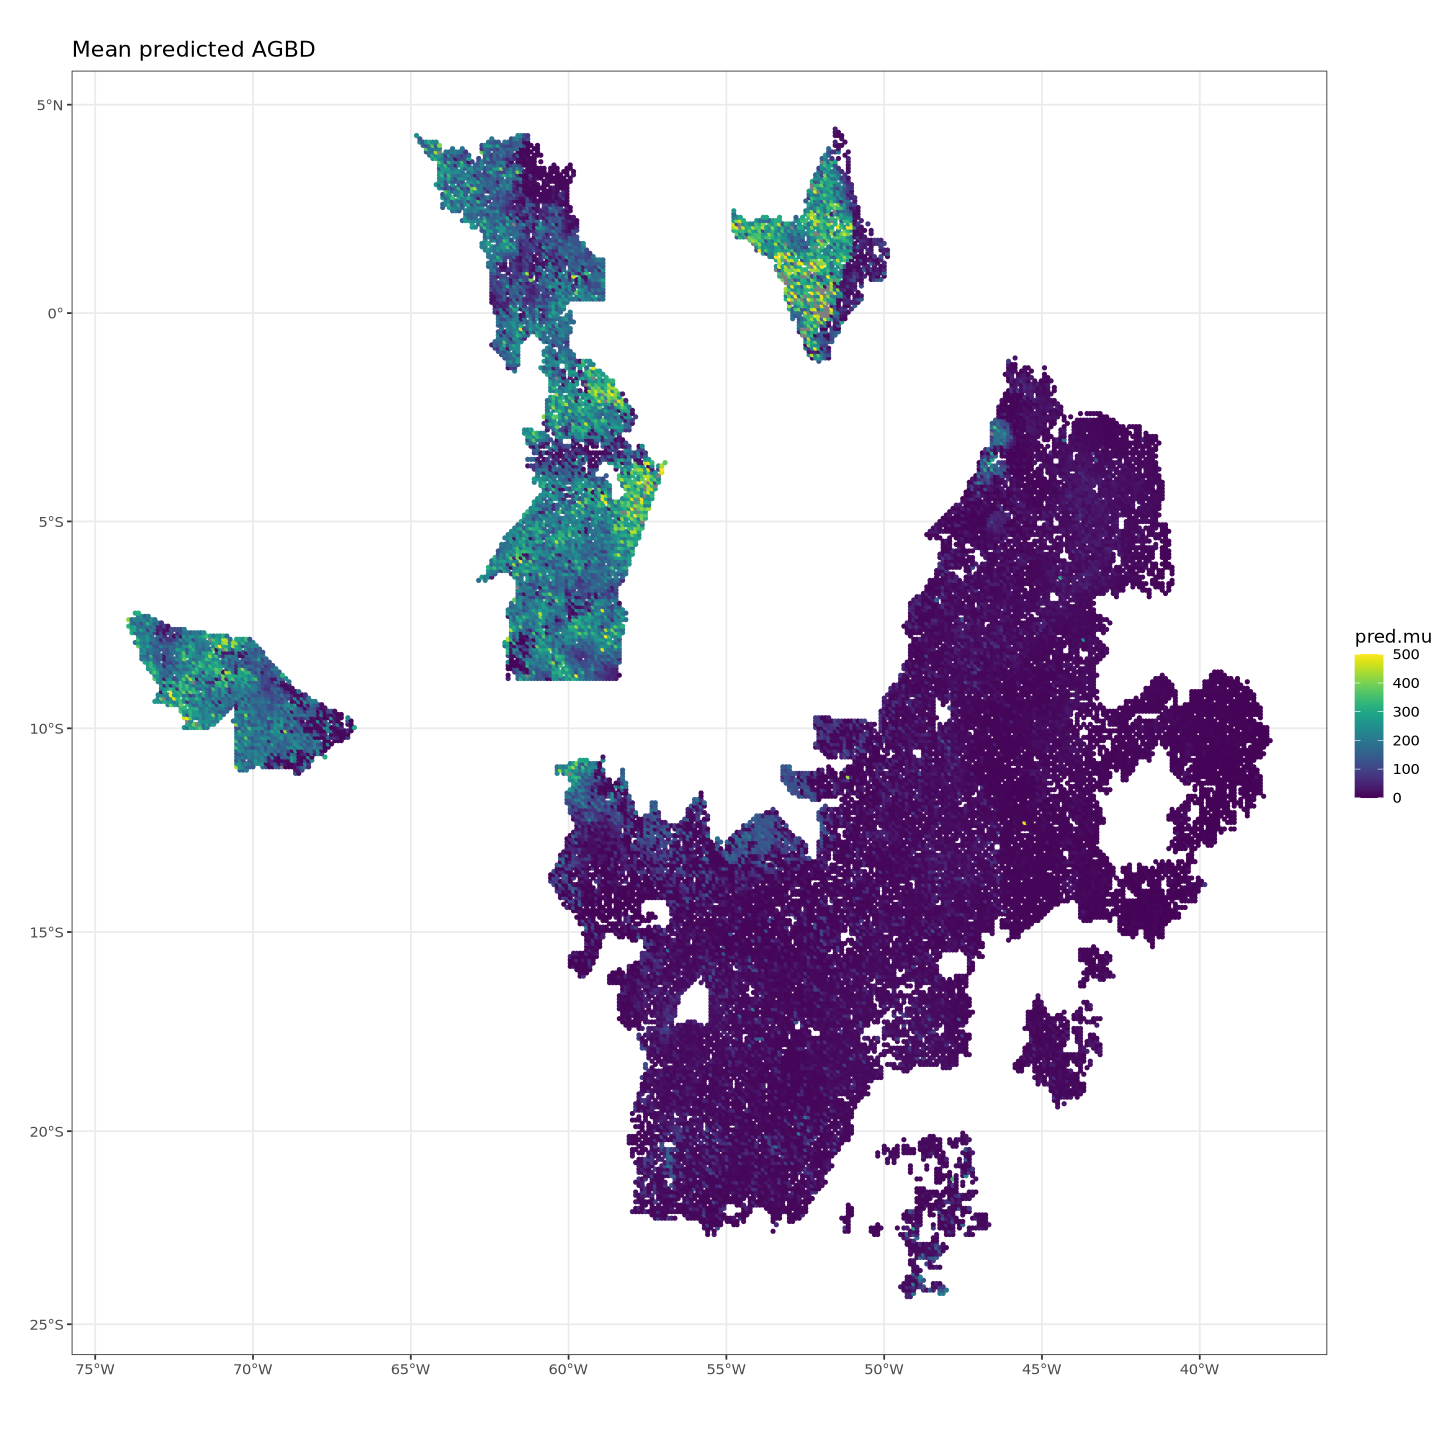

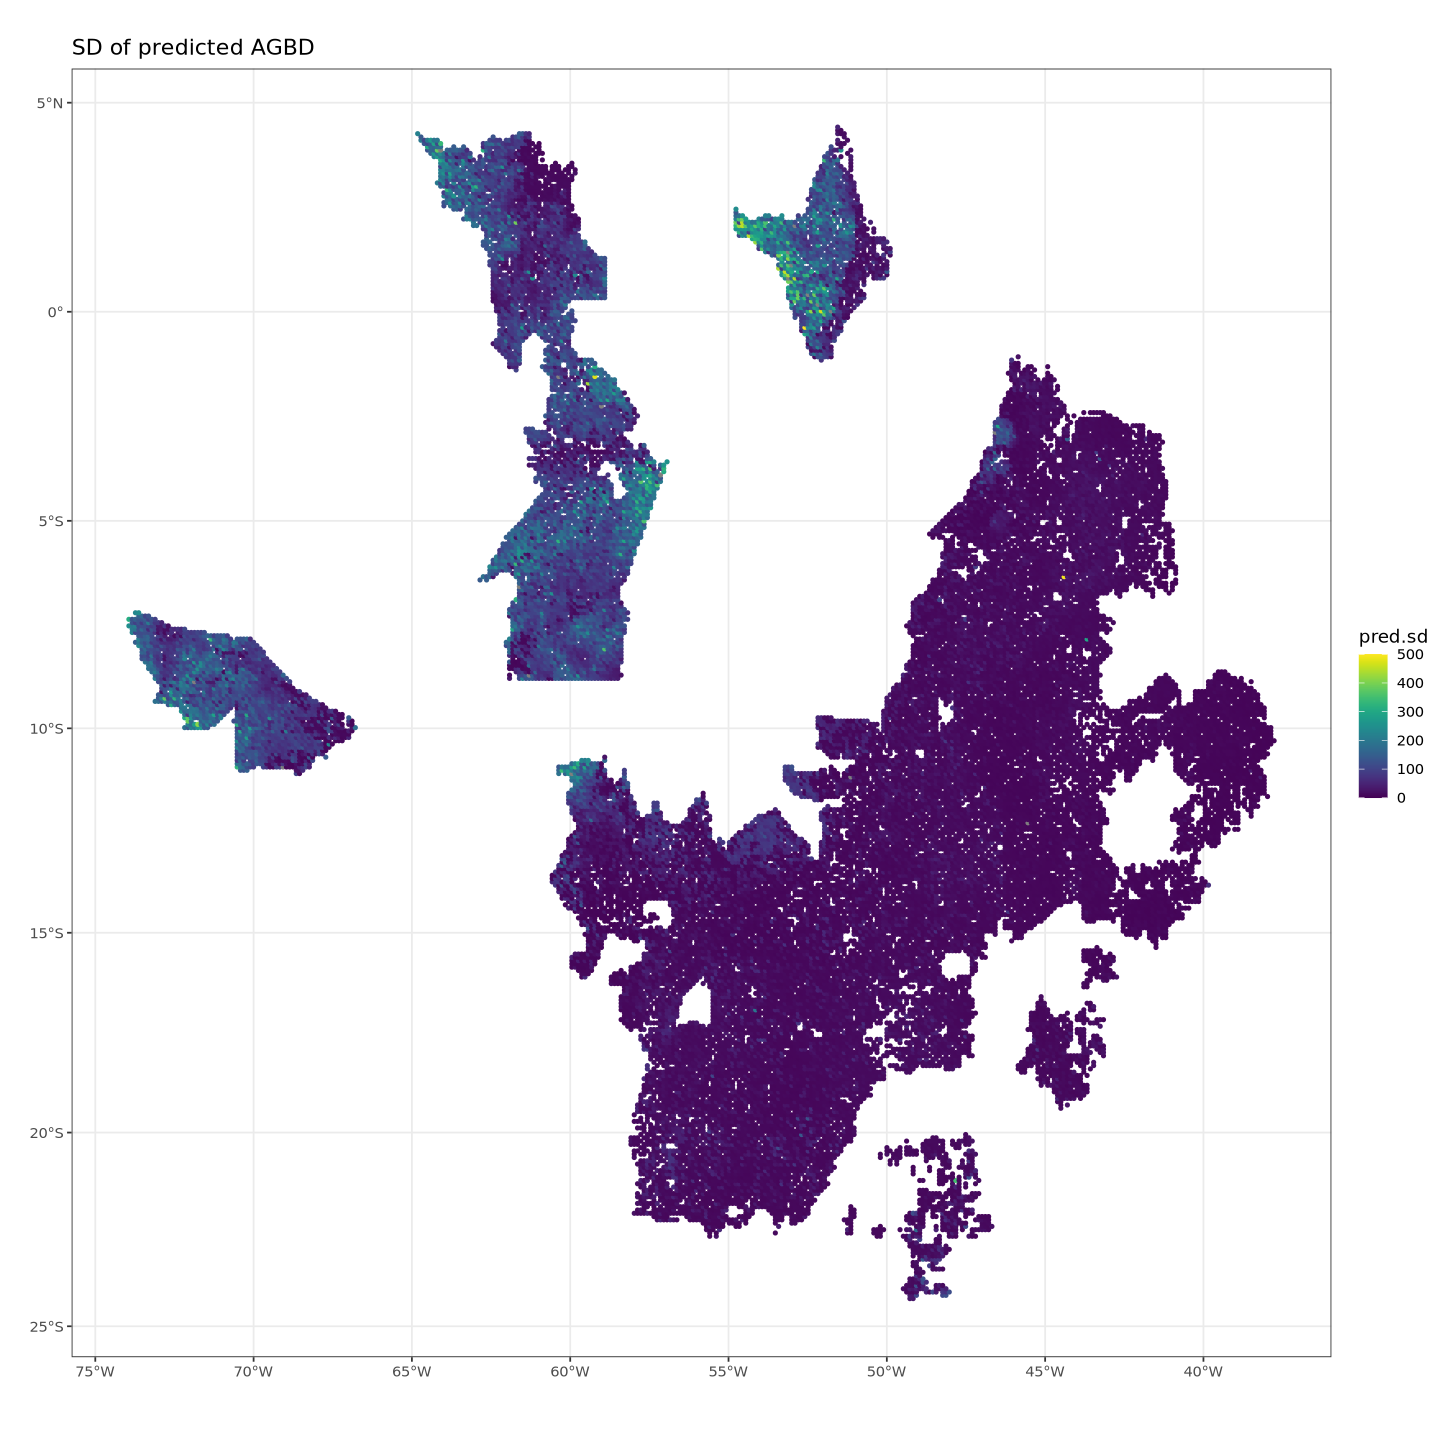

In [43]:
# ###############################################################################
# ################ MAKING FIGURE FOR PREDICTIONS IN ONE PROVINCE ################
# ###############################################################################

# Provinces <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/AOI_provinces.gpkg") %>% st_transform(crs=6933)
# Provinces["AGBD"] <- 0
# Provinces["AGBD_SE"] <- 0

# load("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/INLA_model_fit.RData")
# CCI <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/CCI_Brazil_6933.tif")
# GEDI <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/GEDI_L4A_Brazil_500m.tif") 

# Province_name <- 'Xapuri'
# Province <- Provinces[Provinces$ADM2_PT == Province_name,]
# print(paste("Processing Province: ", Province_name))

# Province <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/Provinces_with_data/AOI_provinces.gpkg") %>% st_transform(crs=6933)
# Provinces["AGBD"] <- 0
# Provinces["AGBD_SE"] <- 0

# grid_to_predict = st_make_grid(Province, cellsize = c(10000,10000), what = "centers") %>% st_as_sf() %>% st_filter(Province)
# grid = as.data.frame(grid_to_predict %>% st_coordinates())

# GEDI.pred = exactextractr::exact_extract(GEDI,st_buffer(grid_to_predict,100), 'mean')
# grid$GEDI.pred <- GEDI.pred

# CCI.pred = exactextractr::exact_extract(CCI,st_buffer(grid_to_predict,100), 'mean')
# CCI.array <- CCI.pred
# grid$CCI.array = CCI.array

# grid_original <- grid
# grid <- grid[(!is.na(grid$CCI.array) & grid$GEDI.pred>0),]
# grid_to_predict <- grid_to_predict[(!is.na(grid_original$CCI.array) & grid_original$GEDI.pred>0),]
# loc.plot_T <- data.matrix(as.data.frame(cbind(grid$X,grid$Y)))

# CCI.pred <- CCI.pred[(!is.na(CCI.array) & GEDI.pred>0)]
# GEDI.pred <- GEDI.pred[(!is.na(CCI.array) & GEDI.pred>0)]

# samples = inla.posterior.sample(n = 250, result = model_fit) # Draw posterior samples from our model fit 
# A.pred = inla.spde.make.A(mesh = mesh, loc = loc.plot_T) # Make a new projector matrix with the same mesh, but new plot locations 

# # Our model function
# pred_fun = function(...){
#   drop(intercept + 
#     GEDI.pred*L4A +
#     CCI.pred*CCI +
#     A.pred%*%alpha.spat[1:k] +   
#     Diagonal(x = GEDI.pred)%*%A.pred%*%beta.spat[1:k] + 
#     Diagonal(x = CCI.pred)%*%A.pred%*%eta.spat[1:k]) +
#     rnorm(nrow(A.pred), sd = sqrt(1/theta[1])) 
# }

# # Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions at our testing plot locations. 
# pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #
# pred.samples[pred.samples < 0] = 0

# # Model mean AGBD expectations and SD's at the grid locations
# pred.mu = Matrix::rowMeans(pred.samples^(1/factor),na.rm=TRUE)
# pred.sd = apply(pred.samples^(1/factor), 1, sd)

# # Model mean AGBD expectations and SD of the strata
# Strata_mean <- round(mean(pred.mu,na.rm=TRUE),digits=2)
# Strata_SD <- round(sd(colMeans(pred.samples^(1/factor), na.rm = T),na.rm=TRUE),digits=2)

# print(paste0("Mean predicted AGBD: ", Strata_mean))
# print(paste0("Predicted SD of AGBD: ", Strata_SD))
# print("------------------------------------------------------")
# Provinces[Provinces$ADM2_PT == Province_name,]$AGBD <- Strata_mean
# Provinces[Provinces$ADM2_PT == Province_name,]$AGBD_SE <- Strata_SD

options(repr.plot.width=12, repr.plot.height=12)
ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.mu),size=0.8) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 500)) + xlab("") + ylab("") + ggtitle("Mean predicted AGBD") + theme(plot.title = element_text(color="red", size=20, face="bold.italic"),axis.text.x = element_text(size = 20)) +
           theme_bw() #+ geom_sf(data = Province,col="red",fill=NA,lwd=0.1)# add our fake deforestation sites


ggplot() + coord_sf(crs = 6933) + 
           geom_point(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], col = pred.sd),size=0.8) +  # make a map to see plot locations and the AGBD values at each location
           scale_color_viridis(limits = c(0, 500)) + xlab("") + ylab("") + ggtitle("SD of predicted AGBD") + theme(plot.title = element_text(color="red", size=14, face="bold.italic"),axis.text = element_text(size = 20)) + 
           theme_bw() #+ geom_sf(data = Province,col="red",fill=NA,lwd=0.1)# add our fake deforestation sites


In [15]:
Provinces$ADM2_PT

[1] "Acrelândia"                   "Assis Brasil"                
   [3] "Brasiléia"                    "Bujari"                      
   [5] "Capixaba"                     "Cruzeiro do Sul"             
   [7] "Epitaciolândia"               "Feijó"                       
   [9] "Jordão"                       "Mâncio Lima"                 
  [11] "Manoel Urbano"                "Marechal Thaumaturgo"        
  [13] "Plácido de Castro"            "Porto Walter"                
  [15] "Rio Branco"                   "Rodrigues Alves"             
  [17] "Santa Rosa do Purus"          "Senador Guiomard"            
  [19] "Sena Madureira"               "Tarauacá"                    
  [21] "Xapuri"                       "Porto Acre"                  
  [23] "Apuí"                         "Autazes"                     
  [25] "Borba"                        "Careiro"                     
  [27] "Careiro da Várzea"            "Iranduba"                    
  [29] "Itacoatiara"                  "Itapiranga"                  
  [31] "Manacapuru"                   "Manaquiri"                   
  [33] "Manaus"                       "Manicoré"                    
  [35] "Maués"                        "Novo Aripuanã"               
  [37] "Presidente Figueiredo"        "Rio Preto da Eva"            
  [39] "São Sebastião do Uatumã"      "Silves"                      
  [41] "Amajari"                      "Alto Alegre"                 
  [43] "Boa Vista"                    "Bonfim"                      
  [45] "Cantá"                        "Caracaraí"                   
  [47] "Caroebe"                      "Iracema"                     
  [49] "Mucajaí"                      "Rorainópolis"                
  [51] "São João da Baliza"           "São Luiz"                    
  [53] "Serra do Navio"               "Amapá"                       
  [55] "Pedra Branca do Amapari"      "Calçoene"                    
  [57] "Cutias"                       "Ferreira Gomes"              
  [59] "Laranjal do Jari"             "Macapá"                      
  [61] "Mazagão"                      "Oiapoque"                    
  [63] "Porto Grande"                 "Pracuúba"                    
  [65] "Santana"                      "Tartarugalzinho"             
  [67] "Vitória do Jari"              "Abreulândia"                 
  [69] "Aguiarnópolis"                "Aliança do Tocantins"        
  [71] "Almas"                        "Alvorada"                    
  [73] "Ananás"                       "Angico"                      
  [75] "Aparecida do Rio Negro"       "Aragominas"                  
  [77] "Araguacema"                   "Araguaçu"                    
  [79] "Araguaína"                    "Araguanã"                    
  [81] "Araguatins"                   "Arapoema"                    
  [83] "Arraias"                      "Augustinópolis"              
  [85] "Aurora do Tocantins"          "Babaçulândia"                
  [87] "Bandeirantes do Tocantins"    "Barra do Ouro"               
  [89] "Barrolândia"                  "Bernardo Sayão"              
  [91] "Bom Jesus do Tocantins"       "Brasilândia do Tocantins"    
  [93] "Brejinho de Nazaré"           "Cachoeirinha"                
  [95] "Campos Lindos"                "Cariri do Tocantins"         
  [97] "Carmolândia"                  "Caseara"                     
  [99] "Centenário"                   "Chapada de Areia"            
 [101] "Chapada da Natividade"        "Colinas do Tocantins"        
 [103] "Conceição do Tocantins"       "Couto Magalhães"             
 [105] "Cristalândia"                 "Crixás do Tocantins"         
 [107] "Darcinópolis"                 "Dianópolis"                  
 [109] "Divinópolis do Tocantins"     "Dois Irmãos do Tocantins"    
 [111] "Dueré"                        "Esperantina"                 
 [113] "Fátima"                       "Figueirópolis"               
 [115] "Filadélfia"                   "Formoso do Araguaia"         
 

In [2]:
# library(INLA)
# library(Matrix)
# library(ggplot2)
# library(viridis)
# library(MatrixModels)

# #################################
# # Fitting a spatial-only coregionalization model. The model is
# #
    # # gedi(s) = int_gedi + A_1(s)w_1 + \epsilon_gedi(s)
    # # nfi(s) = int_nfi + \beta*A_1(s)w_1 + A_2(s)w_2 + \epsilon_nfi(s) # note, here is where A1_mesh_nfi comes in

# #  where the int_gedi and int_nfi are intercepts, A_1(s) and A_2(s) are spatial effects, 
# #  w_1 and w_2 are weights for some of the spatial effects, and epsilon_gedi(s) 
# #  and epsilon_nfi(s) are uncorrelated error terms, with k=1,2,3k=1,2,3.

# # There are two SPDE Gaussian fields now, w_1 and w_2. 
# # The gedi and nfi are able to share information now because w_1 appears in both.
# # Notice that in the nfi equation, w_1 is scaled by coefficient \beta.
# # If \beta = 0, that means no relationship between gedi and nfi.
# # If the variance of \beta*w_1 is large relative to the variance of the remaining terms, A_1(s)w_2 + \epsilon_nfi(s),
# # that indicates a strong relationship between the two.
# # Assuming a good relationship, the dense gedi shots help us learn w_1 at a fine resolution,
# # which in turn helps us predict nfi.

# #########################
# # Simulate data
# #########################

# This is a silly function I wrote to convert sigma/range pairs into INLA's internal parametrization.
# Only necessary for simulation, you can ignore.
# reg2theta = function(reg, nu = 1, alpha = 2){
#   sig = reg[1]
#   rho = reg[2]
#   log.kappa = log(8*nu)/2 - log(rho)
#   log.tau = 0.5*(lgamma(nu) - lgamma(alpha) - log(4*pi)) - log(sig) - nu*log.kappa
#   theta = c(log.tau, log.kappa)
#   return(theta)
# }

# n_nfi = 250
# n_gedi = 5e+3

# # parameters

# sigma1 = 1
# range1 = 0.075
# theta1 = reg2theta(c(sigma1, range1)) # INLA's internal parametrization
# tau1 = 0.5

# sigma2 = sqrt(0.25)
# range2 = 0.15
# theta2 = reg2theta(c(sigma2, range2)) # INLA's internal parametrization
# tau2 = 0.1

# beta = sqrt(0.75)
# intercept_gedi = 3
# intercept_nfi = 4

# # locs n meshes
# set.seed(96)
# loc_gedi = cbind(runif(n_gedi), runif(n_gedi))
# loc_nfi = cbind(runif(n_nfi), runif(n_nfi))

In [4]:
AOI <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/AOI_6933.gpkg")
gedi_full <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID_GEDI/AOI_GEDI_6933.gpkg")
### gedi <- gedi_full[sample(nrow(gedi_full), size = nrow(gedi_full) / 100), ]; set.seed(10)
nfi <- st_read("/projects/my-private-bucket/Data/NFI_data/Brazil/AOI_NFI_6933.gpkg")
nfi <- nfi %>% group_by(UA) %>% summarise(mean = mean(AGB_Mg.ha2))
nfi$AGB_Mg.ha2 <- nfi$mean

Reading layer `AOI_6933' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID/AOI_6933.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 0 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -5929627 ymin: -550690.6 xmax: -5576631 ymax: -81861.58
Projected CRS: WGS 84 / NSIDC EASE-Grid 2.0 Global
Reading layer `AOI_GEDI_6933' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID_GEDI/AOI_GEDI_6933.gpkg' 
  using driver `GPKG'
Simple feature collection with 5141311 features and 8 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -5929627 ymin: -550690.6 xmax: -5576631 ymax: -81861.65
Projected CRS: WGS 84 / NSIDC EASE-Grid 2.0 Global
Reading layer `AOI_NFI_6933' from data source 
  `/projects/my-private-bucket/Data/NFI_data/Brazil/AOI_NFI_6933.gpkg' 
  using driver `GPKG'
Simple feature collection with 530 features and 7 fields
Geometry type: POINT
Dimension:     XY
Bounding box:

In [ ]:
gedi_full$agbd <- gedi_full$agbd[gedi_full$agbd >0]
hist((gedi_full$agbd)^1/20)
hist((nfi$mean)^1/2)

In [26]:
library(exactextractr)
GEDI <- rasterized
GEDI.plot = exactextractr::exact_extract(GEDI,st_buffer(nfi,100), 'mean')
plot(nfi$mean,GEDI.plot)
summary(lm(nfi$mean ~ GEDI.plot))

  |======================================================================| 100%


ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): 'x' and 'y' lengths differ


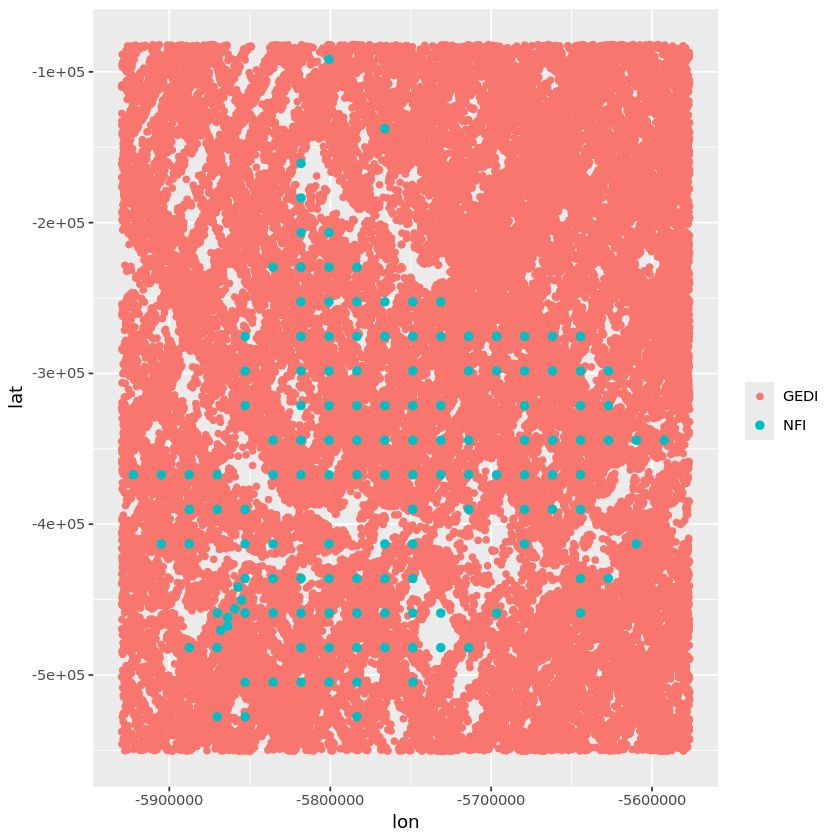

In [59]:
factor <- (1/1)

gedi_coords <- as.data.frame(gedi %>% st_coordinates())
nfi_coords <- as.data.frame(nfi %>% st_coordinates())
loc_gedi = data.matrix(as.data.frame(cbind(gedi_coords$X,gedi_coords$Y)))
loc_nfi = data.matrix(as.data.frame(cbind(nfi_coords$X,nfi_coords$Y)))

ggplot() + geom_point(aes(x = loc_gedi[,1], y = loc_gedi[,2], col = "GEDI")) +
  geom_point(aes(x = loc_nfi[,1], y = loc_nfi[,2], col = "NFI"), size = 2) +
  xlab("lon") + ylab("lat") + labs(col = "")

gedi_nfi <- gedi %>% st_drop_geometry()
nfi_nfi <- nfi %>% st_drop_geometry()

gedi <- (gedi$agbd)
nfi <- (nfi$AGB_Mg.ha2)

In [60]:
factor <- (3)
nfi <- (nfi)^factor

[1] 6408

[1] 1525

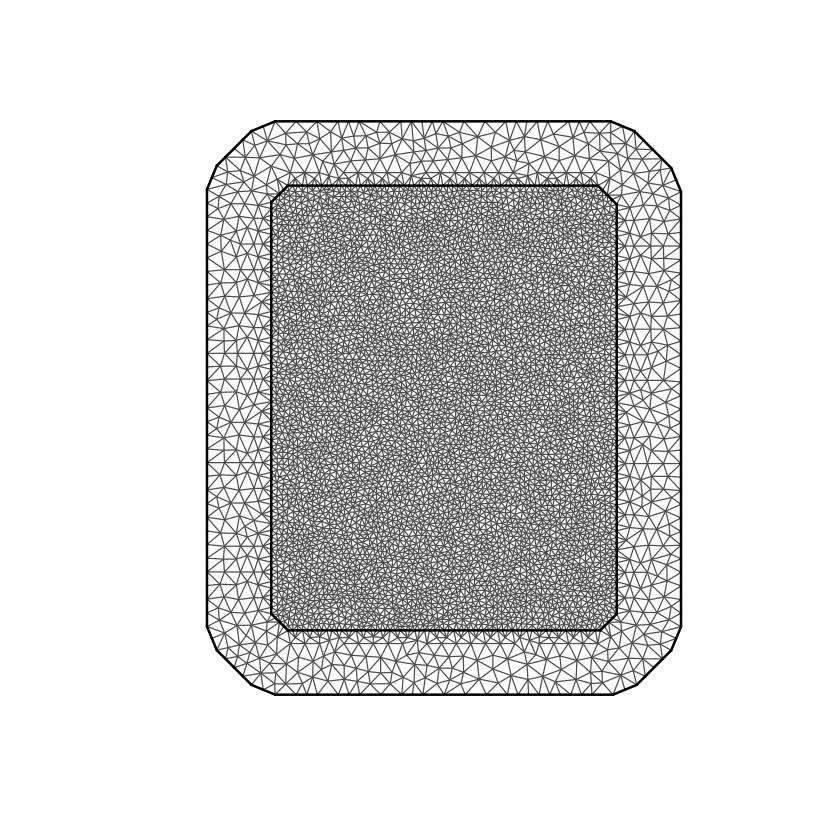

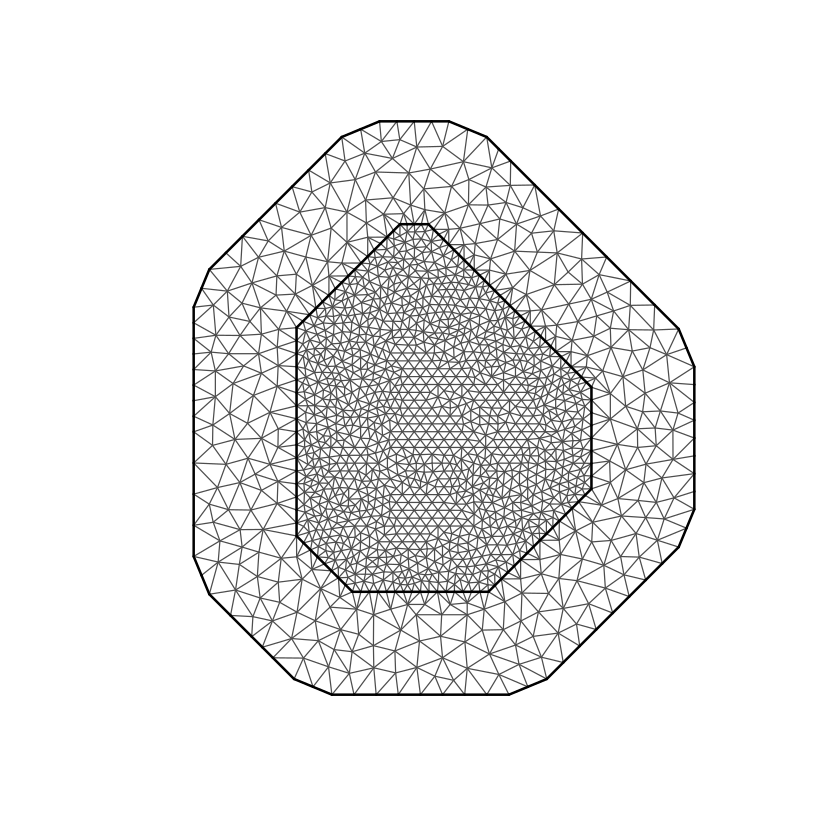

In [63]:
# sigma1 = 1
range1 = 2000 ## try this (about a 5th of your infered range) # check if you're less than 100k nodes roughly. 
# theta1 = reg2theta(c(sigma1, range1)) # INLA's internal parametrization
# tau1 = 0.5

# sigma2 = sqrt(0.25)
range2 = 50000
# theta2 = reg2theta(c(sigma2, range2)) # INLA's internal parametrization
# tau2 = 0.1

# beta = sqrt(0.75)
# intercept_gedi = 3
# intercept_nfi = 4

mesh1 = inla.mesh.2d(loc = loc_gedi, 
                     max.edge = c(range1/5, range1),
                     cutoff = c(range1/5),
                     offset = c(range1, 3*range1))
mesh1$n  
plot(mesh1)

mesh2 = inla.mesh.2d(loc = loc_nfi, 
                     max.edge = c(range2/5, range2),
                     cutoff = c(range2/5),
                     offset = c(range2, 3*range2))
mesh2$n  
plot(mesh2)


# # Sim Gaussian fields and data

spde1 = inla.spde2.matern(mesh1)
spde2 = inla.spde2.matern(mesh2)

# Q1 = inla.spde2.precision(spde1, theta1)
# w1 = inla.qsample(Q = Q1)

# Q2 = inla.spde2.precision(spde2, theta2)
# w2 = inla.qsample(Q = Q2)

A1_gedi = inla.spde.make.A(mesh1, loc_gedi) # projects first mesh on gedi coordinates
A1_nfi = inla.spde.make.A(mesh1, loc_nfi) # projects first mesh on nfi coordinates
A2_nfi = inla.spde.make.A(mesh2, loc_nfi) # projects second mesh on nfi coordinates

# # # gedi = drop(intercept_gedi + A1_gedi%*%w1 + rnorm(n_gedi, sd = tau1) )

# ggplot() + geom_point(aes(x = loc_gedi[,1], y = loc_gedi[,2], col = gedi))  +
#   scale_color_viridis(limits = quantile(gedi, c(0.01, 0.99)), oob = scales::squish) +
#   xlab("lon") + ylab("lat")  + theme_dark()

# # # nfi = drop(intercept_nfi + beta*A1_nfi%*%w1 + A2_nfi%*%w2 + rnorm(n_nfi, sd = tau2))

# ggplot() + geom_point(aes(x = loc_nfi[,1], y = loc_nfi[,2], col = nfi)) +
#   scale_color_viridis(limits = quantile(nfi, c(0.01, 0.99)), oob = scales::squish) +
#   xlab("lon") + ylab("lat") + theme_dark()

In [65]:
######################################################
######################################################
# Fit coregionalization model
######################################################
######################################################

n_gedi = length(gedi)
n_nfi = length(nfi)

# Constructing the stacks and formula for coreg models is the weirdest bit.
# I'll try to explain it as I go.

# Make the gedi stack
stack_gedi = inla.stack(
  data = list(y = cbind(gedi, NA)), # Notice a leave a column open for the NFI observations...
  A = list(1, A1_gedi), # And my A's and effects only include things that are in the gedi equation.
  effects = list(int_gedi = rep(1,n_gedi), w1 = 1:mesh1$n)
)

# Make the nfi stack
stack_nfi = inla.stack(
  data = list(y = cbind(NA, nfi)), # See how the empty slot is swapped?
  A = list(1, A1_nfi, A2_nfi), # Again, only things in the nfi equation.
  effects = list(int_nfi = rep(1,n_nfi), w12 = 1:mesh1$n, w2 = 1:mesh2$n) # w12 is the 'copy' of w1 in the gedi equation, but it needs a unique name. We'll tell INLA it's a copy in the formula lower down.
)

stack_full = inla.stack(stack_gedi, stack_nfi) # Merge 'em.

# Create SPDE objects with PC priors.
spde1 = inla.spde2.pcmatern(
  mesh = mesh1,
  prior.range = c(25000, 0.01), 
  prior.sigma = c(60, 0.01))

spde2 = inla.spde2.pcmatern(
  mesh = mesh2,
  prior.range = c(25000, 0.01), 
  prior.sigma = c(60, 0.01))

# Our normal prior on the beta coefficient. It's a mean and precision parameterization (precision of 2 implies a SD of sqrt(1/2)).
beta_prior <- list(beta = list(prior = 'normal', param = c(1, 2)))

# Last weird bit. You need to list all terms in the equation. INLA will know which go to gedi and the nfi from your individual stacks.

form = y ~ -1 + int_gedi + 
  int_nfi + 
  f(w1, model = spde1) + 
  f(w12, copy = 'w1', fixed = FALSE, hyper = beta_prior) + # This is how we tell INLA w12 is a copy of w1. The 'fixed = FALSE' tells INLA it needs to estimate \beta, rather than fix it at some provided value (default is 1, I think?)
  f(w2, model = spde2)


# Let 'er rip.
coreg_mod = inla(form, rep('gaussian', 2), # The rep('gaussian', 2) tells INLA that both gedi and nfi are assumed to be gaussian.
               data = inla.stack.data(stack_full), 
               control.predictor = list(A = inla.stack.A(stack_full)),
               control.compute = list(config = T, dic = T, waic = T, cpo = T),
               verbose = T)

summary(coreg_mod)
hist(coreg_mod$cpo$pit, breaks = 20) 


 *** inla.core.safe:  The inla program failed, but will rerun in case better initial values may help. try=1/1 


ERROR: Error in inla.core.safe(formula = formula, family = family, contrasts = contrasts, : The inla-program exited with an error. Unless you interupted it yourself, please rerun with verbose=TRUE and check the output carefully.
  If this does not help, please contact the developers at <help@r-inla.org>.
The inla program failed and the maximum number of tries has been reached.


In [ ]:
#####################
# Predict nfi on a regular grid.
# Hopefully this stuff makes sense from your previous work.
#########################

grid_to_predict = st_make_grid(AOI, cellsize = c(5000,5000), what = "centers") %>% st_as_sf()
grid = as.data.frame(grid_to_predict %>% st_coordinates())
loc.plot_T <- data.matrix(as.data.frame(cbind(grid$X,grid$Y)))

n_pred = nrow(loc.plot_T)

A1_pred = inla.spde.make.A(mesh1, loc.plot_T)
A2_pred = inla.spde.make.A(mesh2, loc.plot_T)

nsamps = 250

sample = inla.posterior.sample(n = nsamps, coreg_mod)

coreg_mod$mode$theta # Super janky, but I used this to find out INLA is storing beta in theta[7] and the precision of \epsilon_nfi(s) in theta[2]. I use this info in the prediction function below.

pred_fun = function(...){
  drop(int_nfi + theta[7]*A1_pred%*%w1 + A2_pred%*%w2 + rnorm(n_pred, sd = sqrt(1/theta[2])))
  }

pred.samples = inla.posterior.sample.eval(pred_fun, sample, )


pred_mu = Matrix::rowMeans(pred.samples,na.rm=TRUE)
pred_sd = apply(pred.samples, 1, sd)

ggplot() + geom_raster(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], fill = pred_mu)) +
  scale_fill_viridis(limits = quantile(pred_mu, c(0.01, 0.99)), oob = scales::squish) +
  xlab("lon") + ylab("lat")  + theme_dark()

ggplot() + geom_raster(aes(x = loc.plot_T[,1], y = loc.plot_T[,2], fill = pred_sd)) +
  scale_fill_viridis(option = "turbo", limits = quantile(pred_sd, c(0.01, 0.99)), oob = scales::squish) +
  xlab("lon") + ylab("lat")  + theme_dark()

In [ ]:
# gedi_full <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/BRAZIL/GRID_GEDI/AOI_GEDI_6933.gpkg")

# # Define the desired pixel size (in map units, e.g., meters)
# pixel_size <- 500  # specify the pixel size you want

# # Create an extent for the raster, this will match the extent of the vector data
# extent_data <- st_bbox(gedi_full)  # Get bounding box of the vector data

# # Define the desired resolution of the raster
# raster_extent <- extent(extent_data)

# # Create an empty raster with the defined extent and pixel size
# raster_output <- raster(raster_extent, res = pixel_size)

# # Set the projection of the raster to be the same as the vector data
# crs(raster_output) <- st_crs(gedi_full)$proj4string

# # Rasterize the vector data
# rasterized <- rasterize(gedi_full, raster_output, field = "agbd")  # Replace 'your_field_name' with the field you want to rasterize

# # # Save the raster to a file (e.g., GeoTIFF format)
# # writeRaster(rasterized, "output_raster.tif", format = "GTiff", overwrite = TRUE)

# # Plot the raster
# plot(rasterized)